# Usage Example: PINN Poisson 1D
This notebook demonstrates how to use the PINN library to solve the 1D Poisson equation.

## 1. Install Dependencies
Make sure you have the required packages installed.

In [1]:
!pip install torch torchvision matplotlib numpy pyyaml onnx onnxruntime

   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.7 MB 1.9 MB/s eta 0:00:07
   ---------------------------------------- 0.1/12.7 MB 1.6 MB/s eta 0:00:08
    --------------------------------------- 0.2/12.7 MB 1.1 MB/s eta 0:00:12
    --------------------------------------- 0.2/12.7 MB 1.3 MB/s eta 0:00:10
    --------------------------------------- 0.3/12.7 MB 1.3 MB/s eta 0:00:10
    --------------------------------------- 0.3/12.7 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.4/12.7 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.4/12.7 MB 1.2 MB/s eta 0:00:11
   - -------------------------------------- 0.5/12.7 MB 1.1 MB/s eta 0:00:11
   - -------------------------------------- 0.5/12.7 MB 1.1 MB/s eta 0:00:11
   - -------------------------------------- 0.6/12.7 MB 1.1 MB/s eta 0:00:11
   -- ------------------------------------- 0.7/12.7 MB 1.2 MB/s eta 0:00:11
   -- 


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Library Modules
We assume all `.py` files are in the current directory.

In [2]:
import os
import torch
import numpy as np
import yaml
import matplotlib.pyplot as plt
from pinn import PoissonPINN
from domain import DomainGenerator
from equation import PoissonEquation
from losses import LossFunction
from events import PlotLoss, PlotSolution, Checkpoint, RelativeRMSE, OnnxExport, ProgressBar
from utils import default_poisson_visualizer


## 3. Load Configuration
Load `config.yaml` and override some parameters for a short demo.

In [3]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
print(config)
# Override for demo
config['n_interior'] = 256
config['num_epochs'] = 200
config['plot_loss_freq'] = 50
config['plot_solution_freq'] = 50
config['checkpoint_save_freq'] = 100
config['relative_rmse_freq'] = 100
print('Modified config for demo:', config)


{'pinn_class': 'PoissonPINN', 'layers': [1, 50, 50, 1], 'n_interior': 1024, 'n_boundary': 2, 'optimizer': {'name': 'Adam', 'lr': 0.001}, 'loss_weights': {'residual': 1.0, 'boundary': 1.0, 'data': 0.0}, 'num_epochs': 200, 'device': 'cuda', 'plot_loss_freq': 100, 'plot_solution_freq': 20, 'checkpoint_save_freq': 50, 'relative_rmse_freq': 100, 'onnx': {'export': True, 'export_path': 'models/poisson.onnx', 'opset_version': 13}}
Modified config for demo: {'pinn_class': 'PoissonPINN', 'layers': [1, 50, 50, 1], 'n_interior': 256, 'n_boundary': 2, 'optimizer': {'name': 'Adam', 'lr': 0.001}, 'loss_weights': {'residual': 1.0, 'boundary': 1.0, 'data': 0.0}, 'num_epochs': 200, 'device': 'cuda', 'plot_loss_freq': 50, 'plot_solution_freq': 50, 'checkpoint_save_freq': 100, 'relative_rmse_freq': 100, 'onnx': {'export': True, 'export_path': 'models/poisson.onnx', 'opset_version': 13}}


## 4. Setup Domain and Equation

In [4]:
interior_bounds = np.array([[0.0, 1.0]])
def sample_poisson_boundary(n):
    return np.array([[0.0], [1.0]], dtype=np.float32)
domain = DomainGenerator(
    interior_bounds=interior_bounds,
    boundary_sampler=sample_poisson_boundary,
    data_sampler=None,
    data_values_sampler=None
)
def f_func(x_tensor: torch.Tensor) -> torch.Tensor:
    return torch.sin(torch.pi * x_tensor)
equation = PoissonEquation(f=f_func)


## 5. Initialize Model, Loss, Optimizer, and Callbacks

In [5]:
device = 'cpu'
layers = config['layers']
model = PoissonPINN(layers=layers, equation=equation, activation=torch.nn.Tanh).to(device)
loss_fn = LossFunction(weights=config['loss_weights'])

opt_map = {'Adam': torch.optim.Adam, 'SGD': torch.optim.SGD, 'RMSprop': torch.optim.RMSprop}
optimizer = opt_map[config['optimizer']['name']](model.parameters(), lr=config['optimizer']['lr'])

# Callbacks
events = []
plot_loss = PlotLoss(save_path='plots/loss.png', display=False, plot_freq=config['plot_loss_freq'])
events.append(plot_loss)
x_vis = np.linspace(0, 1, 200).reshape(-1, 1)
sample_points_vis = torch.tensor(x_vis, dtype=torch.float32)
plot_solution = PlotSolution(
    sample_points=sample_points_vis,
    visualizer=default_poisson_visualizer,
    save_dir='plots/solution',
    display=False,
    plot_freq=config['plot_solution_freq']
)
events.append(plot_solution)
checkpoint = Checkpoint(filepath_template='checkpoints/poisson_epoch_{epoch}_loss_{loss:.4f}.pt',
                       save_freq=config['checkpoint_save_freq'])
events.append(checkpoint)
def true_poisson_solution(x_tensor):
    return torch.sin(torch.pi * x_tensor) / (torch.pi**2)
relative_rmse = RelativeRMSE(
    sample_points=sample_points_vis,
    true_solution_fn=true_poisson_solution,
    print_freq=config['relative_rmse_freq']
)
events.append(relative_rmse)
if config.get('onnx', {}).get('export', False):
    onnx_cfg = config['onnx']
    export_path = onnx_cfg.get('export_path', 'models/poisson.onnx')
    opset = onnx_cfg.get('opset_version', 13)
    sample_for_onnx = torch.tensor([[0.5]], dtype=torch.float32)
    onnx_export = OnnxExport(
        export_path=export_path,
        sample_input=sample_for_onnx,
        opset_version=opset,
        export_epoch=config['num_epochs']
    )
    events.append(onnx_export)
progress_bar = ProgressBar(total_epochs=config['num_epochs'], bar_length=30)
events.append(progress_bar)


## 6. Run Training

In [6]:
os.makedirs('plots/solution', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('models', exist_ok=True)
model.train_model(
    domain=domain,
    equation=equation,
    loss_fn=loss_fn,
    optimizer=optimizer,
    events=events,
    
    num_epochs=config['num_epochs'],
    n_interior=config['n_interior'],
    n_boundary=config['n_boundary'],
    device=device
)


Epoch 99/200 [==============                ][Epoch   100] Relative RMSE = 1.122112e-01
Epoch 199/200 [============================= ][Epoch   200] Relative RMSE = 3.400646e-02
ONNX model exported to models/poisson.onnx
Epoch 200/200 [==============================]


## 7. Display Results
### Loss Curve

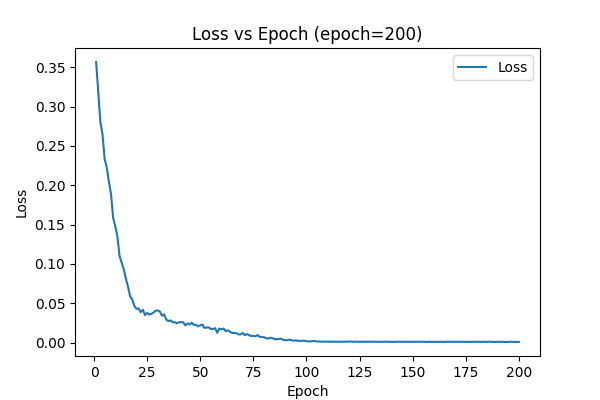

In [2]:
from IPython.display import Image, display
display(Image(filename='plots/loss.png'))


### PINN Solution (Epoch 200)

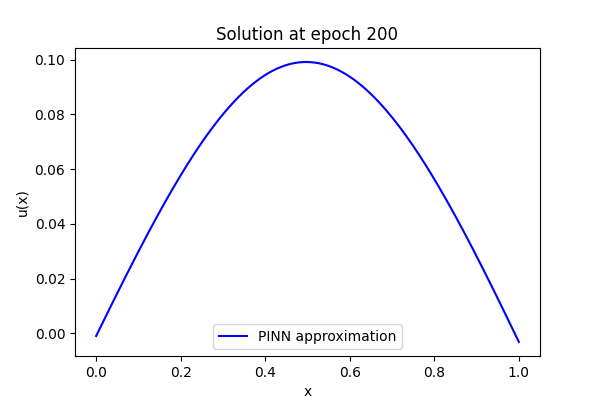

In [3]:
display(Image(filename='plots/solution/solution_epoch_200.png'))
